In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

In [36]:
df = pd.read_csv("./data/preprocessed_data.csv")

In [37]:
df

,time_of_day,time_of_week,time_of_year,hydro,micro,thermal,wind,total,sys_reg,flow,y_prev,y
0,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,341.330021,330.114330
1,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,330.114330,323.877221
2,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,323.877221,296.438463
3,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,296.438463,269.097132
4,14,2,1,1591.839,141.928,11.5,74.428,1819.695,10.0,-4417.4,269.097132,232.113498
...,...,...,...,...,...,...,...,...,...,...,...,...
218471,3,0,3,1942.486,191.881,20.1,106.431,2266.098,0.0,-2252.9,141.026229,141.618915
218472,3,0,3,1942.486,191.881,20.1,106.431,2266.098,0.0,-2252.9,141.618915,129.043820
218473,3,0,3,1942.486,191.881,20.1,106.431,2266.098,0.0,-2252.9,129.043820,94.907548
218474,3,0,3,1942.486,191.881,20.1,106.431,2266.098,0.0,-2252.9,94.907548,102.589040


In [48]:
# split into train and test sets
values = df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_train_hours = 100000
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(100000, 1, 11) (100000,) (118476, 1, 11) (118476,)


Epoch 1/50
1389/1389 - 6s - loss: 0.0475 - val_loss: 0.0622 - 6s/epoch - 4ms/step
Epoch 2/50
1389/1389 - 3s - loss: 0.0280 - val_loss: 0.0309 - 3s/epoch - 2ms/step
Epoch 3/50
1389/1389 - 3s - loss: 0.0122 - val_loss: 0.0326 - 3s/epoch - 2ms/step
Epoch 4/50
1389/1389 - 3s - loss: 0.0111 - val_loss: 0.0338 - 3s/epoch - 2ms/step
Epoch 5/50
1389/1389 - 3s - loss: 0.0101 - val_loss: 0.0257 - 3s/epoch - 2ms/step
Epoch 6/50
1389/1389 - 3s - loss: 0.0092 - val_loss: 0.0235 - 3s/epoch - 2ms/step
Epoch 7/50
1389/1389 - 3s - loss: 0.0096 - val_loss: 0.0237 - 3s/epoch - 2ms/step
Epoch 8/50
1389/1389 - 3s - loss: 0.0094 - val_loss: 0.0230 - 3s/epoch - 2ms/step
Epoch 9/50
1389/1389 - 3s - loss: 0.0099 - val_loss: 0.0246 - 3s/epoch - 2ms/step
Epoch 10/50
1389/1389 - 3s - loss: 0.0090 - val_loss: 0.0240 - 3s/epoch - 2ms/step
Epoch 11/50
1389/1389 - 3s - loss: 0.0097 - val_loss: 0.0246 - 3s/epoch - 2ms/step
Epoch 12/50
1389/1389 - 3s - loss: 0.0091 - val_loss: 0.0241 - 3s/epoch - 2ms/step
Epoch 13/50
1

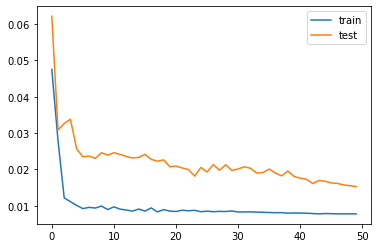

In [39]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [49]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 0:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(118476, 1)
(118476, 12)
Test RMSE: 0.501


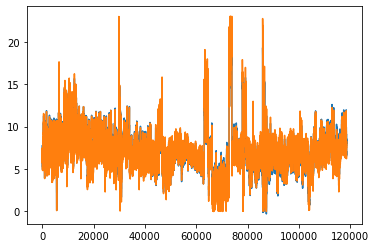

In [51]:
pyplot.plot(inv_yhat)
pyplot.plot(inv_y)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        
    def forward(self, y, future_preds=0):
        outputs, n_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs